Mean P&L: 44.48
Std P&L: 8.29


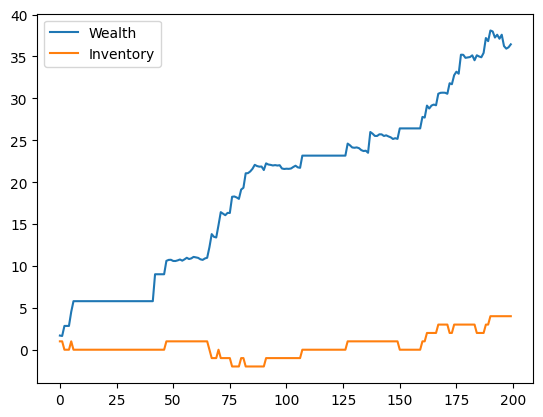

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters (from the paper's simulation)
params = {
    "S0": 100,        # Initial mid-price
    "T": 1,           # Time horizon (e.g., 1 day)
    "sigma": 2,       # Volatility
    "gamma": 0.1,     # Risk aversion
    "k": 1.5,         # Order book depth parameter
    "A": 140,         # Order arrival rate scaling
    "dt": 0.005,      # Time step
    "q0": 0,          # Initial inventory
    "num_sims": 1000  # Number of simulations
}

def simulate_mid_price(params):
    """Simulate mid-price using Brownian motion."""
    n_steps = int(params["T"] / params["dt"])
    dW = np.random.normal(0, np.sqrt(params["dt"]), n_steps)
    S = params["S0"] + params["sigma"] * np.cumsum(dW)
    return S

def compute_reservation_price(S_t, q, t, params):
    """Reservation price: r = S_t - q * gamma * sigma^2 * (T - t)."""
    T_minus_t = params["T"] - t
    return S_t - q * params["gamma"] * (params["sigma"] ** 2) * T_minus_t

def compute_optimal_spreads(params, t):
    """Optimal bid/ask spreads (simplified closed-form)."""
    spread = params["gamma"] * (params["sigma"] ** 2) * (params["T"] - t) + (2 / params["gamma"]) * np.log(1 + params["gamma"] / params["k"])
    return spread # Symmetric around reservation price
def compute_order_arrival_intensities(params, spread_bid, spread_ask):
    lambda_bid = params["A"] * np.exp(-params["k"] * spread_bid)
    lambda_ask = params["A"] * np.exp(-params["k"] * spread_ask)
    return lambda_bid, lambda_ask
def run_simulation(params):
    """Run one simulation of the inventory-based strategy."""
    n_steps = int(params["T"] / params["dt"])
    S = simulate_mid_price(params)
    cash = 0
    inventory = params["q0"]
    wealth = np.zeros(n_steps)
    q_hist = np.zeros(n_steps)

    for i in range(n_steps):
        t = i * params["dt"]
        r = compute_reservation_price(S[i], inventory, t, params)
        spread = compute_optimal_spreads(params, t)
        p_bid = r - spread  # Reservation bid price
        p_ask = r + spread  # Reservation ask price

        spread_bid = S[i] - p_bid
        spread_ask = p_ask - S[i]
        
        # Simulate order arrivals (Poisson processes)
        lambda_bid, lambda_ask = compute_order_arrival_intensities(params, spread_bid, spread_ask)

        # Check if bid/ask orders are executed
        if np.random.rand() < lambda_bid * params["dt"]:
            cash -= p_bid
            inventory += 1
        if np.random.rand() < lambda_ask * params["dt"]:
            cash += p_ask
            inventory -= 1

        # Update wealth (X + qS)
        wealth[i] = cash + inventory * S[i]
        q_hist[i] = inventory

    return wealth, q_hist

# Run multiple simulations
results = [run_simulation(params) for _ in range(params["num_sims"])]
profits = [res[0][-1] for res in results]  # Terminal wealth

# Analyze results
print(f"Mean P&L: {np.mean(profits):.2f}")
print(f"Std P&L: {np.std(profits):.2f}")

# Plot sample simulation
plt.plot(results[0][0], label='Wealth')
plt.plot(results[0][1], label='Inventory')
plt.legend()
plt.show()